This is a summary and cleaner version of the jupyter lab called: http://127.0.0.1:8888/lab/tree/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Get_data_for_modeing_4.ipynb

In this juper lab: 

    1. I first create a LSTM mode, with one input which are IFR of has two output : Sin and Cos of the angle of the animal around the lever
    2. Load the ifr of the cells (Mostly FS) and sin and cos of the angle of the animal around the lever 
    3. Generate the the model and get the labels and output and calculate the mse of the model 
    4. Reconstruct the angle of the animal around the lever and compare it to the predicted angle from the model 
    5. Calculate the shuffle value for angle of the animal around the lever and run the model on shuffled data. 
    6. Compare the r and mse from the shufled data with the original data. 
    
    7. Repeat this for all the sessions with at least 10 FS
    

Here I mostly wanted to load the result from the shuffeling and check if they worked for the sessions where the shuffling worked .. its in Shuffled_values forder

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *

In [2]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[130:153],myProject.sessionList[130:153]) ### sSeslist >>>> sSessions


Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████| 180/180 [03:50<00:00,  1.28s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [4]:
for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
#for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
#for ses, sSes in tqdm(zip(myProject.sessionList[130:153],sSessions[130:153])):
    getSearchHomingIntervals(ses, sSes)

180it [00:05, 31.38it/s]


In [5]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)
###
#df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 56.9 ms, sys: 7.09 ms, total: 64 ms
Wall time: 89.8 ms


In [6]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    
    return sSes,ses,n, nid 


In [7]:
def load_pose_around_lever_for_modeling(ses,sSes, interName= 'all_light' ,maxDistance= 18, rotationType="none", 
                                        invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12, ctype= 'fs' ):

    sSes.load_parameters_from_files()
    sSes.load_parameters_from_files()
    sSes.ap.load_pose_from_file() # get original hd data,

    ## Transfer the x,y position of the animal to the Lever Reference frame 
    toLeverReferenceFrame(ses=ses,sSes=sSes,maxDistance=maxDistance, rotationType="none", invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12)

    sSes.ap.set_intervals(ses.intervalDict[interName])
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(sSes)
    cg = Cell_group(stl, sSes.ap)

    # create a list of cells (spikeA.Neuron)
    if ctype== 'fs' :
        cids = cells[(cells.session == sSes.name) & (cells.mrate_RF1> 10) & (cells.interneuron)].cluId

    elif ctype== 'gc':
        cids = cells[(cells.session == sSes.name) & (cells.gridCell_FIRST)].cluId
    else:
        cids = cells[(cells.session == sSes.name)].cluId

    cIds = [cid.split("_")[1] for cid in cids]
    cg.sc_list = [n for n in cg.neuron_list if n.name in cIds]

    return sSes.ap, cg

In [8]:
def get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses,interName= 'all_light', ctype= 'fs',  sigma_ifr= 5, maxDistance= 18, rotationType="none" ):
    """
    Get ifr  and the movement direction of the animal that matches the ap.pose samples
    
    """
    # load session files
    ap, cg = load_pose_around_lever_for_modeling(ses,sSes, interName= interName,maxDistance= maxDistance, rotationType=rotationType, 
                                        invalidateSmallBridgeAngle= False,invalidateMaxAngle=np.pi/12, ctype= ctype)
    
    # trick to get aligned ifr and pose data
    time = ap.pose[:,0]
    bin_size_sec = np.diff(time)[0]
    
    pose = ap.pose[:,1:3]
    keepIndices = ~(np.isnan(pose[:,1]))
    pose= pose[keepIndices]
    
    angles = np.arctan2(pose[:,1], pose[:,0]) ## get values between -3,3 
    magnitude = np.sqrt(pose[:,0]**2 + pose[:,1]**2)
    #angles = np.mod(angles + 2 * np.pi, 2 * np.pi) ## get values between 0, 2*pi
    # Compute the sine and cosine of the angle
    sin_angle = pose[:,1] / magnitude
    cos_angle = pose[:,0] / magnitude

    sin_cos_angles = np.column_stack((sin_angle, cos_angle))
    
    if len(cg.sc_list)!= 0:

        for n in cg.sc_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            n.spike_train.instantaneous_firing_rate(bin_size_sec = bin_size_sec, sigma= sigma_ifr, time_start=min(time)-bin_size_sec/2, 
                                                time_end=max(time), outside_interval_solution="remove")

       
        ifr = np.stack([n.spike_train.ifr[0][keepIndices] for n in cg.sc_list])

        #### aligne the shape 
        time = time[keepIndices]
        ifr= ifr[:,:-1]
        time= time[:-1]
 
    else:
        ifr= np.nan
        time= time[:-1]

    return ifr, pose[:-1,:], time, angles[:-1], sin_cos_angles[:-1,:]

# Build the lstm model 


In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import mean_squared_error 
import datetime


class NeuralDataset(torch.utils.data.Dataset):
    """
    Represent our pose and neural data.
    
    """
    def __init__(self, ifr, sin, cos, time, seq_length,ifr_normalization_means=None,ifr_normalization_stds=None):    
        """
        ifr: instantaneous firing rate
        angle: angle of the animal around the lever from -pi to pi 
        seq_length: length of the data passed to the network
        """
        super(NeuralDataset, self).__init__()
        self.ifr = ifr.astype(np.float32)
        #self.sin_cos_angles = sin_cos_angles.astype(np.float32)
        self.sin = sin.astype(np.float32)
        self.cos= cos.astype(np.float32)
        self.time = time.astype(np.float32)
        self.seq_length = seq_length
        
        self.ifr_normalization_means=ifr_normalization_means
        self.ifr_normalization_stds=ifr_normalization_stds
        
        self.normalize_ifr()
        
        #self.validIndices = np.argwhere(~np.isnan(self.angel[:]))
        self.validIndices = np.argwhere(~np.isnan(self.sin[:]))
        self.validIndices = self.validIndices[self.validIndices>seq_length] # make sure we have enough neural dat leading to the angles
   
        
    def normalize_ifr(self):
        """
        Set the mean of each neuron to 0 and std to 1
        Neural networks work best with inputs in this range
        Set maximal values at -5.0 and 5 to avoid extreme data points
        
        ###########
        # warning #
        ###########
        
        In some situation, you should use the normalization of the training set to normalize your test set.
        For instance, if the test set is very short, you might have a very poor estimate of the mean and std, or the std might be undefined if a neuron is silent.
        """
        if self.ifr_normalization_means is None:
            self.ifr_normalization_means = self.ifr.mean(axis=0)
            self.ifr_normalization_stds = self.ifr.std(axis=0)
            
        self.ifr = (self.ifr-np.expand_dims(self.ifr_normalization_means,0))/np.expand_dims(self.ifr_normalization_stds,axis=0)
        self.ifr[self.ifr> 5.0] = 5.0
        self.ifr[self.ifr< -5.0] = -5.0
        
        
    def __len__(self):
        return len(self.validIndices)
    
    def __getitem__(self,index):
        """
        Function to get an item from the dataset
        
        Returns angles, neural data
        
        """
        neuralData = self.ifr[self.validIndices[index]-self.seq_length:self.validIndices[index],:]
        #sin_cos_angles = self.angle[self.validIndices[index]:self.validIndices[index]+1,:]#. 2d array 
        sin= self.sin[self.validIndices[index]:self.validIndices[index]+1].squeeze()  # Squeeze to get shape [1] instead of [1, 1]
        cos= self.cos[self.validIndices[index]:self.validIndices[index]+1].squeeze()  # Squeeze to get shape [1] instead of [1, 1]
        time = self.time[self.validIndices[index]:self.validIndices[index]+1]
        
        #return torch.from_numpy(neuralData), torch.from_numpy(sin_cos_angles).squeeze(), torch.from_numpy(time) # if I return sin_cos_angle in a 2d array
        return torch.from_numpy(neuralData), torch.from_numpy(sin), torch.from_numpy(cos), torch.from_numpy(time)
    
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_outputs, sequence_length, device):
        super(LSTM,self).__init__()
        """
        For more information about nn.LSTM -> https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        """
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size,hidden_size, num_layers, batch_first=True)
        # input : batch_size x sequence x features
        self.device = device
        self.fc = torch.nn.Linear(hidden_size*sequence_length, num_outputs) # if you onely want to use the last hidden state (hidden_state,num_classes)
        #self.fc = torch.nn.Linear(hidden_size * sequence_length, 2)  # Output two values for sin and cos but in a single 2d array  
        
    def forward(self,x):
        
        h0 =  torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(self.device)
        c0 =  torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(self.device) 
        out, _ = self.lstm(x,(h0,c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out) #if you want to use only the last hidden state, remove previous line, # out = self.fc(out[:,-1,:])
        
        return out

In [9]:
def split_to_test_andTraining(ifr, pose, sin_cos_angles, time, angles):

    split_index = int(ifr.shape[1] * 0.8)  # 80% of the data along the second axis
    train_ifr = ifr[:, :split_index]  # First 80% for training
    test_ifr = ifr[:, split_index:]
    
    train_pose= pose[:split_index, :]
    test_pose= pose[split_index:, :]
    
    train_sin_cos_angles= sin_cos_angles[:split_index, :]
    test_sin_cos_angles= sin_cos_angles[split_index:, :]
    
    train_time=time[:split_index]
    test_time= time[split_index:]
    
    train_angles=angles[:split_index]
    test_angles= angles[split_index:]
    
    return train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles

import numpy as np

def get_shuffled_data(interName, sin_cos_angles, ses, min_roll_sec=20):
    # Get the interval times for the specified interName
    intervals = ses.intervalDict[interName]
    total_time_sec = intervals[:, 1][-1] - intervals[:, 0][0]

    # Ensure the total interval duration is larger than 2 * min_roll_sec
    if total_time_sec < 2 * min_roll_sec:
        raise ValueError("Total time in intervals should be larger than 2 * min_roll_sec")

    # Generate a random shift within the allowed range
    time_shift = np.random.default_rng().uniform(min_roll_sec, total_time_sec - min_roll_sec, 1)
    angles = np.arctan2(sin_cos_angles[:, 0], sin_cos_angles[:, 1])

    # Calculate time per data point
    time_per_datapoint = angles[1] - angles[0]
    shift = int(time_shift / time_per_datapoint)

    # Apply the shift to the angles
    rolled_angles = np.roll(angles, shift=shift, axis=0)

    # Convert the shifted angles back to sin and cos components
    rolled_sin_cos = np.column_stack((np.sin(rolled_angles), np.cos(rolled_angles)))

    return rolled_sin_cos


In [10]:
def get_test_training_datas_oneSession(sSes, ses, interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none", shuffle=True):

    # 1. Split the time interval for training and testing
    intervals= ses.intervalDict[interName]
    ifr, pose, time, angles, sin_cos_angles = get_session_ifr_pose_angle_aroundlever_for_model(sSes,ses, interName= interName, ctype= ctype,  sigma_ifr= sigma_ifr, maxDistance= maxDistance, rotationType= rotationType )
    
    if shuffle: 
        sin_cos_angles_shuffled= get_shuffled_data( interName, sin_cos_angles,ses, min_roll_sec=20)
        train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles = split_to_test_andTraining(ifr,
                                pose, sin_cos_angles_shuffled, time, angles)
        train_ifr = train_ifr.T 
        test_ifr = test_ifr.T

    
    else: 
        
        train_pose,test_pose, train_ifr, test_ifr, train_sin_cos_angles, test_sin_cos_angles, train_time,test_time, train_angles, test_angles = split_to_test_andTraining(ifr, pose, sin_cos_angles, time, angles)
        train_ifr = train_ifr.T 
        test_ifr = test_ifr.T
    
    ####################
    ### Get the config file 
    #############
    ###################

    config = {"seq_length":20, ## is this the length of the 
              "n_cells": train_ifr.shape[1], ## it was the num of cells for one neuron is always 1
              "hidden_size" :256,
              "num_layers" : 2,
              "num_outputs" : 2, # 2 number of vector unit in x and y since I want to calculate the movement direction 
              "learning_rate" : 0.001,#0.001, ## 0.001 ( sme was )
              "dropout_rate": 0.05,
              "batch_size" :64, #64,
              "num_epochs": 100}

    print(datetime.datetime.now(), config)
    #print(datetime.now(), config)
    # 4. Create train and test datasets
    train_dataset = NeuralDataset(
        ifr=train_ifr[:, :config["n_cells"]],
        #angle=train_angles,
        sin= train_sin_cos_angles[:,0], ### instead of 
        cos= train_sin_cos_angles[:,1],
        time=train_time,
        seq_length=config["seq_length"]
    )

    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds

    myDict = {
        "ifr_normalization_means": ifr_normalization_means,
        "ifr_normalization_stds": ifr_normalization_stds
    }

    test_dataset = NeuralDataset(
        ifr=test_ifr[:, :config["n_cells"]],
        #angle=test_angles,
        sin= test_sin_cos_angles[:,0],
        cos= test_sin_cos_angles[:,1],
        time=test_time,
        seq_length=config["seq_length"],
        ifr_normalization_means=ifr_normalization_means,
        ifr_normalization_stds=ifr_normalization_stds)

    # 5. Create data loaders
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config["batch_size"],
        num_workers=1, shuffle=True, pin_memory=False, drop_last=True)

    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config["batch_size"],
        num_workers=1, shuffle=False, pin_memory=False)

    return train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config

def lossOnTestDataset(model, test_data_loader, device, loss_fn):
    model.eval()
    loss_test = 0
    with torch.no_grad():
        for imgs, sin_labels, cos_labels, time in test_data_loader:
            imgs = imgs.to(device)
            sin_labels = sin_labels.to(device)
            cos_labels = cos_labels.to(device)

            outputs = model(imgs)  # Model outputs both sin and cos
            
            # Assume outputs[:, 0] is for sin and outputs[:, 1] is for cos
            sin_outputs = outputs[:, 0]
            cos_outputs = outputs[:, 1]

            # Calculate loss for both sin and cos
            loss_sin = loss_fn(sin_outputs, sin_labels)
            loss_cos = loss_fn(cos_outputs, cos_labels)
            
            # Total loss (sum of both)
            loss = loss_sin + loss_cos
            loss_test += loss.item()
    
    model.train()  # Set model back to training mode
    
    if len(test_data_loader) == 0:  # Handle case where the loader is empty
        return float('inf')  # Or return some placeholder value to indicate no test data
    
    return loss_test / len(test_data_loader)


def training_loop(n_epochs,
                  optimizer,
                  model,
                  loss_fn,
                  train_data_loader,
                  test_data_loader,
                  config,
                  device,
                  verbose=False,
                  best_loss=float('inf'),
                  best_model_state=None):
    
    if verbose:
        print("Training starting at {}".format(datetime.datetime.now()))
    
    # Evaluate initial loss without training
    testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)
    trainLoss = lossOnTestDataset(model, train_data_loader, device, loss_fn)
    
    if verbose:
        print(f"Test loss without training: {testLoss}")
    
    df = pd.DataFrame({
        "epochs": [0],
        "seq_length": config["seq_length"],
        "n_cells": config["n_cells"],
        "hidden_size": config["hidden_size"],
        "num_layers": config["num_layers"],
        "learning_rate": config["learning_rate"],
        "batch_size": config["batch_size"],
        "train_loss": trainLoss,
        "test_loss": testLoss
    })

    for epoch in range(1, n_epochs + 1):
        loss_train = 0
        model.train()  # Set model to training mode

        for imgs, sin_labels, cos_labels, time in train_data_loader:  # Expect 4 values
            imgs = imgs.to(device)
            sin_labels = sin_labels.to(device).squeeze()  # Ensure sin_labels shape is [64] instead of [64, 1]
            cos_labels = cos_labels.to(device).squeeze()  # Ensure cos_labels shape is [64] instead of [64, 1]

            # Forward pass
            outputs = model(imgs)  # Model outputs both sin and cos
            sin_outputs = outputs[:, 0]  # First output is sin
            cos_outputs = outputs[:, 1]  # Second output is cos

            # Compute losses for both sin and cos predictions
            loss_sin = loss_fn(sin_outputs, sin_labels)
            loss_cos = loss_fn(cos_outputs, cos_labels)

            # Total loss as the sum of both
            loss = loss_sin + loss_cos

            optimizer.zero_grad()  # Clear gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            loss_train += loss.item()  # Accumulate loss
        
        # Calculate loss on test set
        testLoss = lossOnTestDataset(model, test_data_loader, device, loss_fn)

        if verbose:
            print(f"{datetime.datetime.now()} Epoch: {epoch}/{n_epochs}, "
                  f"Training loss: {loss_train/len(train_data_loader)}, "
                  f"Testing loss: {testLoss}")

        # Record training statistics
        df1 = pd.DataFrame({
            "epochs": [epoch],
            "seq_length": config["seq_length"],
            "n_cells": config["n_cells"],
            "hidden_size": config["hidden_size"],
            "num_layers": config["num_layers"],
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "train_loss": loss_train / len(train_data_loader),
            "test_loss": testLoss
        })

        df = pd.concat([df, df1])

        # Save the best model state based on test loss
        if testLoss < best_loss:
            best_loss = testLoss
            best_model_state = model.state_dict()

    return df, best_model_state


In [11]:
def Makeprediction(model, test_data_loader, device):
    model.eval()
    labellists_sin = []
    labellists_cos = []
    outputlists_sin = []
    outputlists_cos = []
    
    with torch.no_grad():
        for imgs, sin_labels, cos_labels, time in test_data_loader:  # mini-batches with data loader
            imgs = imgs.to(device=device)
            
            # Move labels to CPU
            sin_labels = sin_labels.to('cpu').numpy()
            cos_labels = cos_labels.to('cpu').numpy()
            
            # Predict outputs
            outputs = model(imgs)
            sin_outputs = outputs[:, 0].to('cpu').detach().numpy()  # First output: sin
            cos_outputs = outputs[:, 1].to('cpu').detach().numpy()  # Second output: cos

            # Append predictions and labels
            outputlists_sin.append(sin_outputs)
            outputlists_cos.append(cos_outputs)
            labellists_sin.append(sin_labels)
            labellists_cos.append(cos_labels)
    
    return labellists_sin, labellists_cos, outputlists_sin, outputlists_cos

def get_labels_and_outputs_mse(model, test_data_loader, device):
    ''' 
        This is a func to run the models on the slected cell types and
        returns:
        
         1. mean square error of the model
         2. labesl and the outputs (concatenated for the selected cells)
         
    '''
    
    #labellists, outputlists = Makeprediction(model,test_data_loader,device=device)
    labellists_sin, labellists_cos, outputlists_sin, outputlists_cos= Makeprediction(model, test_data_loader, device)
    labels_sin= np.concatenate(labellists_sin)
    labels_cos= np.concatenate(labellists_cos)
    outputs_sin= np.concatenate(outputlists_sin)
    outputs_cos= np.concatenate(outputlists_cos)
        
    outputs= np.column_stack((outputs_sin, outputs_cos))
    labels= np.column_stack((labels_sin, labels_cos))
    
    mse_sin= mean_squared_error(labels_sin,outputs_sin) 
    mse_cos= mean_squared_error(labels_cos,outputs_cos)
    
    #mse= np.column_stack((mse_sin, mse_cos))
    mse = (mse_sin, mse_cos)
    
    return mse, outputs, labels

Make a fuction to make the model and retunr the outputs and labels 

In [12]:
def run_evalute_model(sSes, ses, interName,cells, ctype="fs", sigma_ifr=5): 
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:
        
        ## get test and training dataset
        train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses,
                                                            interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none", shuffle=False)
        ### get my model 
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
        #print("Device available:", device)

        #optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
        optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
        loss_fn = torch.nn.MSELoss() # 
        model.train()


        ### train the model 
        df, best_model_state = training_loop(n_epochs=config["num_epochs"],
                     optimizer=optimizer,
                     model = model,
                     loss_fn = loss_fn,
                     train_data_loader=train_data_loader,
                     test_data_loader=test_data_loader, #changed to look at prediction in training dataset
                     config=config,
                     device = device,
                     verbose=True)
    
        mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
        mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)

        myMetrics= {'df': df, 
                    "config": config,
                   'mse_test': mse_test, 
                   'outputs_test': outputs_test, 
                    'labels_test': labels_test, 
                    'mse_train': mse_train, 
                    'outputs_train': outputs_train,
                    'labels_train':labels_train
               }
        
    else:
        myMetrics=np.nan
    return myMetrics

In [13]:
def Plot_labes_outPuts_from_model(gs,  df,config, labels_test, labels_train, outputs_train, outputs_test, mse_train, mse_test ):
    

    ax= fig.add_subplot(gs[0,0])
    ax.plot(df.epochs, df.train_loss, label= 'Train.')
    ax.plot(df.epochs, df.test_loss, label= 'Test')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc= 'center')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss values')
    ax.set_title('n_epochs:{} ' .format(config['num_epochs']), fontsize=9)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,1])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,0], outputs_train[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,0], outputs_train[:,0])
    circr= abs(circcorrcoef(labels_train[:,0], outputs_train[:,0])) 

    # plot the identity line
    ax.plot([min(labels_train[:,0]), max(labels_train[:,0])], [min(labels_train[:,0]), max(labels_train[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, SinAngle' .format(r,circr, mse_train[0]), fontsize=9)
    # Add legend
    plt.legend()


    ax= fig.add_subplot(gs[0,2])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,0], outputs_test[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r,p= pearsonr(labels_test[:,0], outputs_test[:,0])
    circr= abs(circcorrcoef(labels_test[:,0], outputs_test[:,0])) 

    # plot the identity line
    ax.plot([min(labels_test[:,0]), max(labels_test[:,0])], [min(labels_test[:,0]), max(labels_test[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, SinAngle' .format(r,circr, mse_test[0]), fontsize=9)
    # Add legend
    #ax.legend(loc='upper center', bbox_to_anchor=(1, 1.3), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,3])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,1], outputs_train[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,1], outputs_train[:,1]) ## labels are the Angles
    circr= circcorrcoef(labels_train[:,1], outputs_train[:,1]) ## outputs are the pred_angles
    # plot the identity line
    ax.plot([min(labels_train[:,1]), max(labels_train[:,1])], [min(labels_train[:,1]), max(labels_train[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, CosAngle' .format(r,circr, mse_train[1]), fontsize=9)
    # Add legend


    ax= fig.add_subplot(gs[0,4])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,1], outputs_test[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles ')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_test[:,1], outputs_test[:,1])
    circr= abs(circcorrcoef(labels_test[:,1], outputs_test[:,1])) 

    # plot the identity line
    ax.plot([min(labels_test[:,1]), max(labels_test[:,1])], [min(labels_test[:,1]), max(labels_test[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, CosAngle' .format(r,circr, mse_test[1]), fontsize=9)
    # Add legend

    ###########################
    #### plot the original angle vs predicted angle in test and training datasets: 
    #############################

    Angle_train = np.arctan2(labels_train[:,0], labels_train[:,1])
    Angle_train_pred = np.arctan2(outputs_train[:,0], outputs_train[:,1])


    Angle_test = np.arctan2(labels_test[:,0], labels_test[:,1])
    Angle_test_pred = np.arctan2(outputs_test[:,0], outputs_test[:,1])

    ################
    ##################
    ##
    ###############
    ##############
    ax= fig.add_subplot(gs[1,0])
    ax.scatter(Angle_train, Angle_train_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_train, Angle_train_pred)
    circr= abs(circcorrcoef(Angle_train, Angle_train_pred)) 

    ax.set_title('Train dataset \n r:{:.2f} \n cir.r: {:.2f}'.format(r,circr ), fontsize=9)

    # plot the identity line
    ax.plot([min(Angle_train), max(Angle_train)], [min(Angle_train_pred), max(Angle_train_pred)], color='red', label=f'Iden. line')


    ax= fig.add_subplot(gs[1,1])
    ax.scatter(Angle_test, Angle_test_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_test, Angle_test_pred)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))

    ax.set_title('Test dataset \n r:{:.2f}  \n cir.r: {:.2f}'.format(r, circr), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_test), max(Angle_test)], [min(Angle_test_pred), max(Angle_test_pred)], color='red', label=f'Iden. line')


    ## 
    ax= fig.add_subplot(gs[1,2])
    sns.histplot(Angle_train, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_train_pred, color='r', label='Predi. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Train', fontsize=9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


    ax= fig.add_subplot(gs[1,3])
    sns.histplot(Angle_test, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_test_pred, color='r', label='Predic. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Test. from model', fontsize= 9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend()

## Test on other sessions 

In [22]:
filtered_cells = cells[(cells['interneuron']) & (cells['mrate_RF1'] > 10)]
session_counts = filtered_cells.groupby('session').size()

# Count how many sessions have more than one FS cell meeting the criteria
num_sessions = (session_counts >= 10).sum()
sessionList = session_counts[session_counts >= 7].index.tolist()
num_sessions, sessionList


(8,
 ['jp3129-03062022-0108',
  'jp452-09112022-0108',
  'jp486-01032023-0108',
  'jp486-02032023-0108',
  'jp486-03032023-0108',
  'jp486-05032023-0108',
  'jp486-06032023-0108',
  'jp486-07032023-0108',
  'jp486-09032023-0108',
  'jp486-10032023-0108',
  'jp486-13032023-0108',
  'jp486-14032023-0108',
  'jp486-15032023-0108',
  'jp486-16032023-0108',
  'jp486-17032023-0108',
  'jp486-18032023-0108',
  'jp486-19032023-0108',
  'jp486-20032023-0108',
  'jp486-22032023-0108',
  'jp486-27022023-0108',
  'jp499-24052023-0108',
  'mn8599-19012022-0107'])

In [48]:
sessionList[0]
Mylists=[]
for sesName in sessionList:
    Mylists.append([sSes.name for sSes in sSessions].index(sesName)) 

In [36]:
Mylists

[146, 149, 139, 152, 142, 132, 131, 140]

In [52]:
myMetrics.keys()

dict_keys(['df', 'mse_test', 'outputs_test', 'labels_test', 'mse_train', 'outputs_train', 'labels_train'])

2024-11-07 15:23:38.179049 {'seq_length': 20, 'n_cells': 14, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 2, 'learning_rate': 0.001, 'dropout_rate': 0.05, 'batch_size': 64, 'num_epochs': 100}


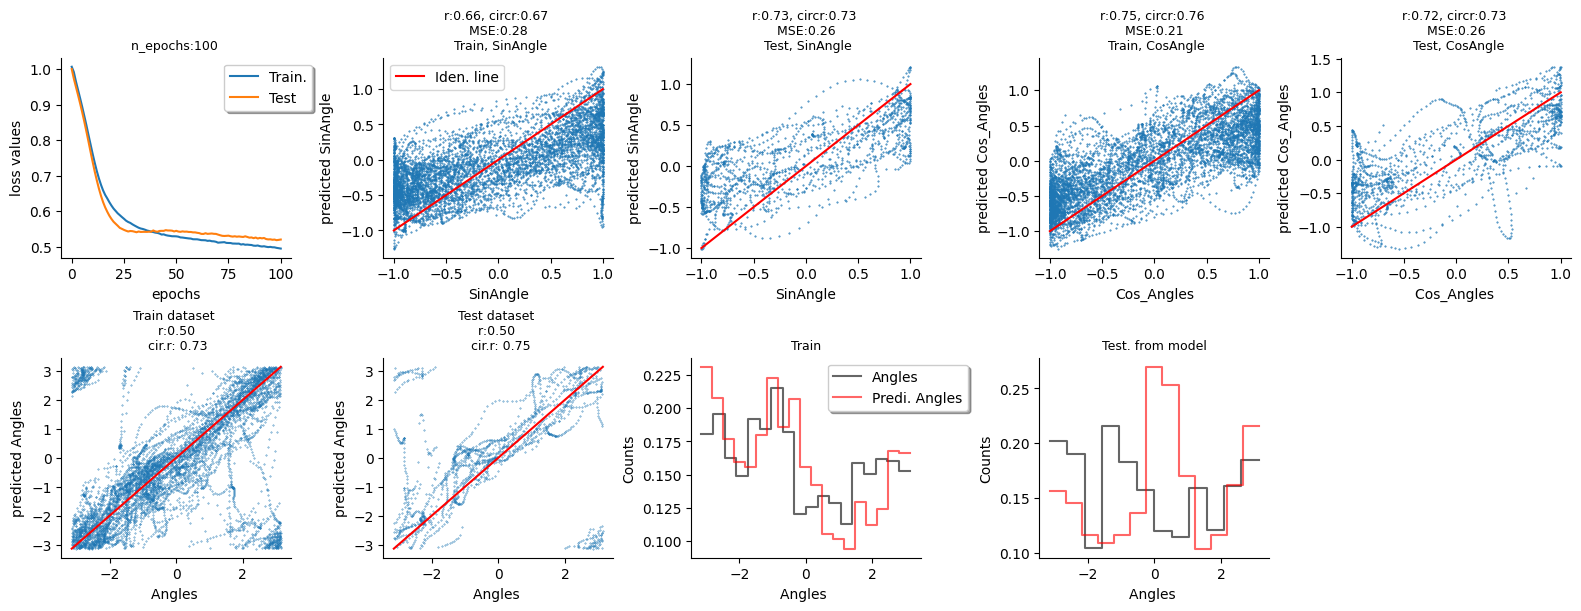

In [55]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


ses= myProject.sessionList[152]
sSes= sSessions[152]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'

myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
Plot_labes_outPuts_from_model(gs,  myMetrics['df'], myMetrics['config'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])


## Check a function to run the shuffling:

In [15]:

def run_and_evaluate_model_shuffle(sSes, ses, cells,interName, ctype='fs', sigma_ifr=5, shuffle=True):
    
    ## Get the test and train Dataset for each shuffle
    train_dataset, test_dataset, train_loader, test_loader, _, config = get_test_training_datas_oneSession(
        sSes, ses, cells,interName, ctype=ctype, sigma_ifr=sigma_ifr, shuffle=shuffle
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"], config["seq_length"], device=device).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])
    loss_fn = torch.nn.MSELoss()

    # Train the model
    df, _ = training_loop(
        n_epochs=config["num_epochs"], optimizer=optimizer, model=model,
        loss_fn=loss_fn, train_data_loader=train_loader, test_data_loader=test_loader,
        config=config, device=device, verbose=False
    )

    # Get labels and predictions
    mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_loader, device)
    mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_loader, device)

    # Calculate angles
    angles = {}
    
    for split, labels, outputs in zip(['train', 'test'], [labels_train, labels_test], [outputs_train, outputs_test]):
        angles[f'{split}_shuffled'] = np.arctan2(labels[:, 0], labels[:, 1])
        angles[f'{split}_pred_shuffled'] = np.arctan2(outputs[:, 0], outputs[:, 1])

    # Calculate correlations
    metrics = {
        'r_train': pearsonr(angles['train_shuffled'], angles['train_pred_shuffled'])[0],
        'circr_train': circcorrcoef(angles['train_shuffled'], angles['train_pred_shuffled']),
        'r_test': pearsonr(angles['test_shuffled'], angles['test_pred_shuffled'])[0],
        'circr_test': circcorrcoef(angles['test_shuffled'], angles['test_pred_shuffled']),
        'df': df,
    }


    return {**angles, **metrics}

def Get_shuffle_values_one_session(sSes, ses, cells,interName, iteration= 500): 
    results = []
    for _ in tqdm(range(iteration)):
        angles_and_metrics = run_and_evaluate_model_shuffle(sSes, ses, cells,interName, ctype='fs', sigma_ifr=5, shuffle=True)
        results.append(angles_and_metrics)

    # Convert results to a DataFrame
    df_sSes = pd.DataFrame(results)
      
    return df_sSes
    
def process_session_intervals_withShuffles(sSes, ses, interNames, cells, iteration=500):
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    
    if FS_count <= 10 and FS_count >= 7 :
        for interName in interNames:
            # Define the file path
            filename = f"{sSes.name}_{interName}_shuffled_values.pkl"
            file_path = os.path.join(save_directory, filename)
            
            # Check if the file already exists
            if os.path.exists(file_path):
                print(f"File {filename} already exists. Skipping.")
                continue  # Skip to the next interval if file exists
            
            # Process each interval and save the DataFrame
            df_sSes = Get_shuffle_values_one_session(sSes, ses,cells, interName, iteration=iteration)
            df_sSes.to_pickle(file_path)
            print(f"Saved data for {filename} at {file_path}")
            del df_sSes
            gc.collect()
            

def process_session_wrapper(session_pair, interNames, cells, iteration):
    sSes, ses = session_pair  # Unpack the session pair
    #print(sSes)
    process_session_intervals_withShuffles(sSes, ses, interNames, cells, iteration=iteration)
    pass


In [6]:
from multiprocessing import Pool
from functools import partial
import os
from datetime import datetime
from tqdm import tqdm
import traceback
from concurrent.futures import ProcessPoolExecutor
from lstmModel import *
save_directory ='/home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_values/'
os.makedirs(save_directory, exist_ok=True)


iteration = 500


In [7]:
iteration

500

In [ ]:
# Track start time
from datetime import datetime
now = datetime.now()
print("Start time:", now.strftime("%d/%m/%Y %H:%M:%S"))
interNames = ['atLever_light']
# Run in parallel using Pool
with Pool(4) as pool:
    # Use partial to pass fixed arguments to the wrapper function
    process_func = partial(process_session_wrapper, interNames=interNames, cells=cells, iteration=iteration)
    
    # Zip the two session lists and process each session pair in parallel
    session_pairs = list(zip(sSessions[:], myProject.sessionList[:])) 
    #session_pairs = list(zip(sSessions[131:132], myProject.sessionList[131:132]))
    pool.map(process_func, session_pairs)


# Track end time
now = datetime.now()
print("End time:", now.strftime("%d/%m/%Y %H:%M:%S"))



Start time: 11/11/2024 12:15:15
File mn8599-19012022-0107_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp3129-03062022-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp452-09112022-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-14032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
jp486-20032023-0108


  0%|                                                   | 0/500 [00:00<?, ?it/s]

File jp486-13032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-16032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
jp486-18032023-0108


  0%|                                                   | 0/500 [00:00<?, ?it/s]

File jp486-27022023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
jp486-01032023-0108


  0%|                                                   | 0/500 [00:00<?, ?it/s]

File jp499-24052023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.


 32%|███████████▊                         | 159/500 [2:19:26<4:57:46, 52.39s/it]

In [ ]:
print(torch.__version__)      # PyTorch version
print(torch.version.cuda)     # CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Check if CUDA is available

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## evaluate the shuffling :

In [64]:
def plot_shuffled_rvalues_oneSession(gs,df_sSes, Angle_test, Angle_test_pred ,iteration= 500 ):

    
    ax= fig.add_subplot(gs[0])
    ax.hist(df_sSes.r_test)
    threshold= np.percentile(df_sSes.r_test,95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    ax.axvline(x=r_original, color='red', linestyle='-', linewidth=2, label='ori. r')
    ax.set_title(f'Test dataset \n itteration:{iteration}, n_fs:{df_sSes.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Pearson r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


    ax= fig.add_subplot(gs[1])
    ax.hist(abs(df_sSes.circr_test))
    threshold= np.percentile(abs(df_sSes.circr_test),95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    ax.axvline(x=circr, color='red', linestyle='-', linewidth=2, label='ori. circr')
    ax.set_title(f'Test dataset \n itteration:{iteration}, n_fs:{df_sSes.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Circular r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


In [ ]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

fn = f"Shuffled_values/{sSes.name}_{interName}_shuffled_values.pkl"
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_shuffled_rvalues_oneSession(gs,shuffle, Angle_test, Angle_test_pred ,iteration= 500 )